In [1]:
from numpy.random import seed
seed(101)

In [2]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential

In [3]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

In [5]:
import os
import cv2

In [6]:
import imageio
import skimage
import skimage.io
import skimage.transform
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [7]:
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
NUM_AUG_IMAGES_WANTED = 1000 
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

In [9]:
print(len(os.listdir('Dataset1/Dataset1/CXR_png')))
print(len(os.listdir('Dataset2/Dataset2/CXR_png')))

663
139


In [10]:
shen_image_list = os.listdir('Dataset1/Dataset1/CXR_png')
mont_image_list = os.listdir('Dataset2/Dataset2/CXR_png')

In [11]:
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

In [12]:
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

In [13]:
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

In [14]:
print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [15]:
df_shen.head()

,image_id
0,CHNCXR_0001_0.png
1,CHNCXR_0002_0.png
2,CHNCXR_0003_0.png
3,CHNCXR_0004_0.png
4,CHNCXR_0005_0.png


In [16]:
df_mont.head()

,image_id
0,MCUCXR_0001_0.png
1,MCUCXR_0002_0.png
2,MCUCXR_0003_0.png
3,MCUCXR_0004_0.png
4,MCUCXR_0005_0.png


In [17]:
def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Thoracic'

In [18]:
df_shen['target'] = df_shen['image_id'].apply(extract_target)
df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [19]:
df_shen['target'].value_counts()

Thoracic    336
Normal      326
Name: target, dtype: int64

In [20]:
df_mont['target'].value_counts()

Normal      80
Thoracic    58
Name: target, dtype: int64

In [21]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories)))
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) 
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

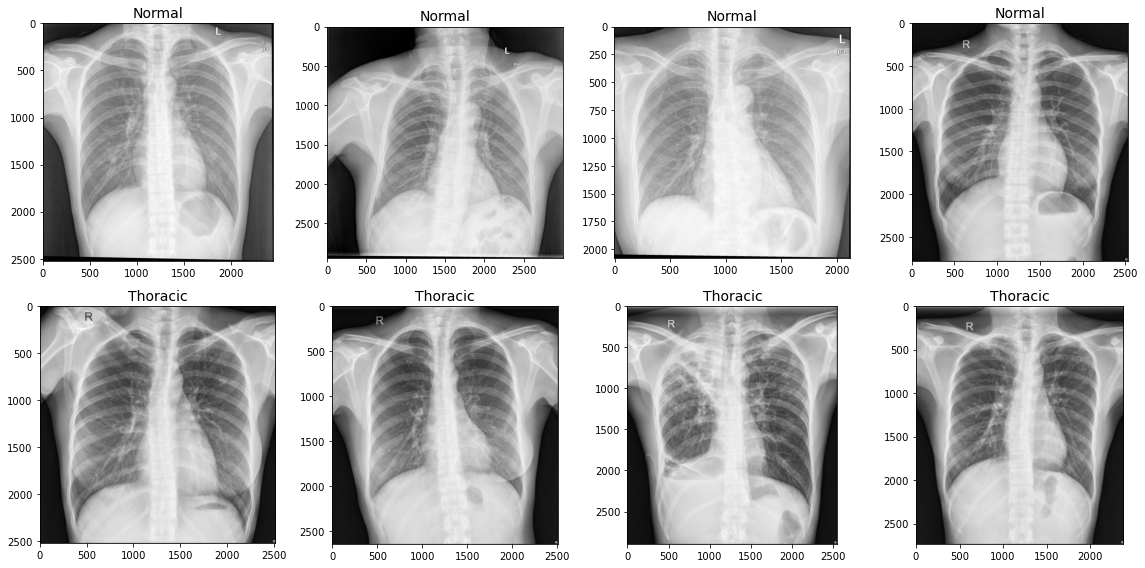

In [22]:
# Shenzen Dataset

IMAGE_PATH = 'Dataset1/Dataset1/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

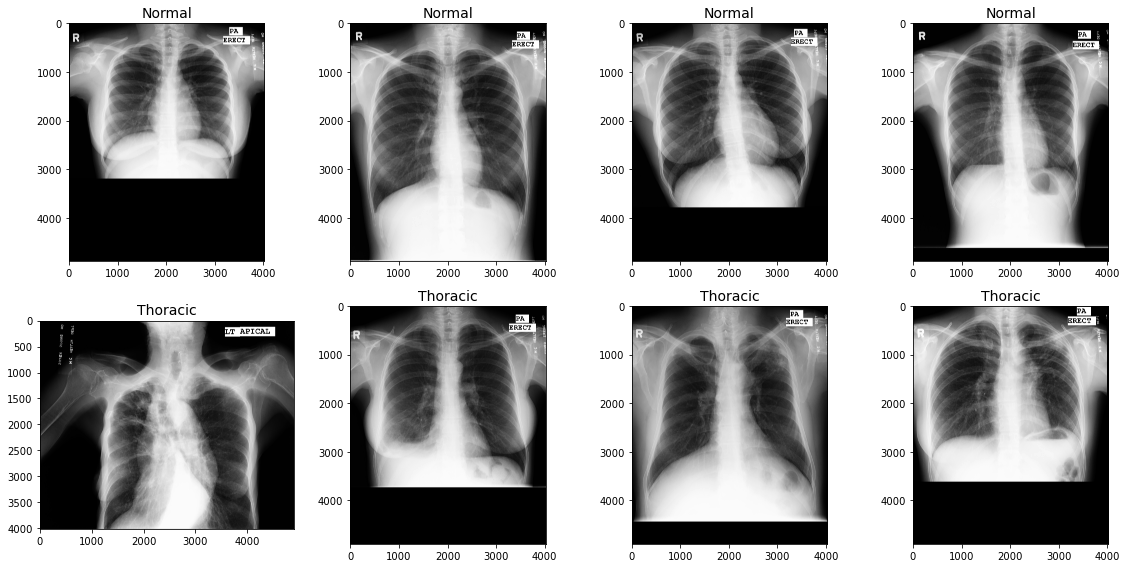

In [23]:
IMAGE_PATH = 'Dataset2/Dataset2/CXR_png/'
draw_category_images('target',4, df_mont, IMAGE_PATH)

In [24]:
def read_image_sizes(file_name):
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    if len(image.shape) > 2: 
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output



In [25]:
IMAGE_PATH = 'Dataset1/Dataset1/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0001_0.png,Normal,2919,3000,3,255,0
1,CHNCXR_0002_0.png,Normal,2951,3000,3,255,0
2,CHNCXR_0003_0.png,Normal,2945,2987,3,255,0
3,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
4,CHNCXR_0005_0.png,Normal,2933,3000,3,255,0


In [26]:
IMAGE_PATH = 'Dataset2/Dataset2/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0005_0.png,Normal,4892,4020,3,255,0


In [27]:
df_shen['c'].value_counts()

3    662
Name: c, dtype: int64

In [28]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

In [29]:
df_mont['target'].value_counts()

Normal      80
Thoracic    58
Name: target, dtype: int64

In [30]:
df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

In [31]:
df_data['labels'] = df_data['target'].map({'Normal':0, 'Thoracic':1})

In [32]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
679,MCUCXR_0024_0.png,Normal,4892,4020,3,255,0,0
177,CHNCXR_0178_0.png,Normal,1341,1521,3,255,0,0
60,CHNCXR_0061_0.png,Normal,2955,3000,3,255,0,0
782,MCUCXR_0316_1.png,Thoracic,4892,4020,3,255,0,1
667,MCUCXR_0006_0.png,Normal,4020,4892,3,255,0,0


In [33]:
y = df_data['labels']

In [34]:
df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

In [35]:
print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [36]:
df_train['target'].value_counts()

Normal      345
Thoracic    335
Name: target, dtype: int64

In [37]:
df_val['target'].value_counts()

Normal      61
Thoracic    59
Name: target, dtype: int64

In [38]:
base_dir = 'base_dir'
shutil.rmtree('base_dir', ignore_errors=True)
os.mkdir(base_dir)

In [39]:
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Thoracic = os.path.join(train_dir, 'Thoracic')
os.mkdir(Thoracic)

Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Thoracic = os.path.join(val_dir, 'Thoracic')
os.mkdir(Thoracic)

In [40]:
df_data.set_index('image_id', inplace=True)

In [41]:
folder_1 = os.listdir('Dataset1/Dataset1/CXR_png')
folder_2 = os.listdir('Dataset2/Dataset2/CXR_png')

In [42]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

In [43]:
for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        src = os.path.join('Dataset1/Dataset1/CXR_png', fname)
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

    if fname in folder_2:
        src = os.path.join('Dataset2/Dataset2/CXR_png', fname)
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        src = os.path.join('Dataset1/Dataset1/CXR_png', fname)
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

    if fname in folder_2:
        src = os.path.join('Dataset2/Dataset2/CXR_png', fname)
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)


In [44]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Thoracic')))

345
335


In [45]:
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Thoracic')))

61
59


In [46]:
class_list = ['Normal','Thoracic']

for item in class_list:
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item
    img_list = os.listdir('base_dir/train_dir/' + img_class)
    for fname in img_list:
            
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            
            dst = os.path.join(img_dir, fname)
            
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
    shutil.rmtree('aug_dir')

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.


In [47]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Thoracic')))

1035
1005


In [48]:
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Thoracic')))

61
59


In [49]:
def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        


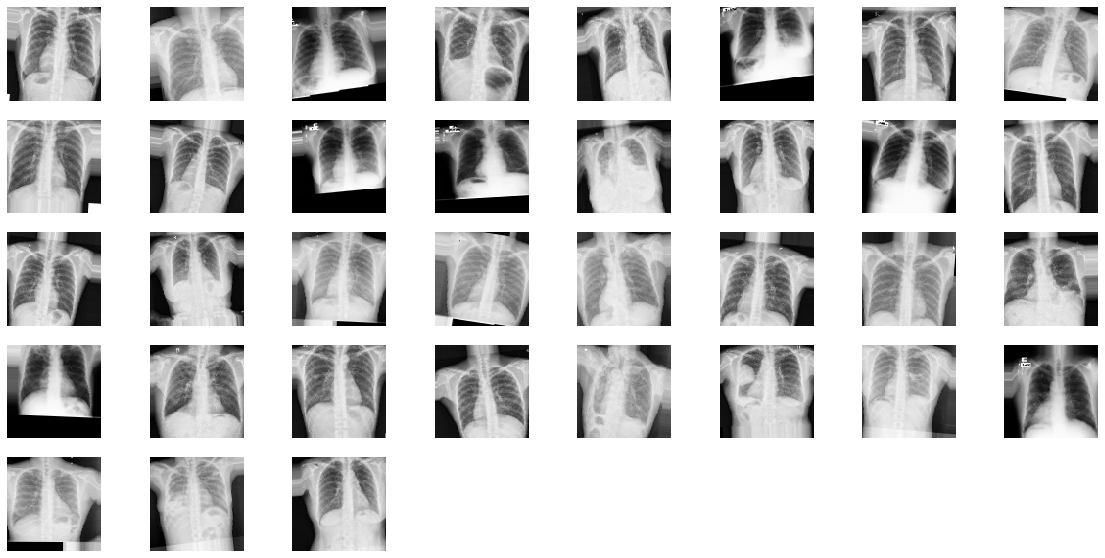

In [50]:
plots(imgs, titles=None) 

In [51]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

In [52]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

In [53]:
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [54]:
datagen = ImageDataGenerator(rescale=1.0/255)

In [55]:
train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

Found 2040 images belonging to 2 classes.


In [56]:
val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 120 images belonging to 2 classes.


In [57]:
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 120 images belonging to 2 classes.


In [58]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.3

In [59]:
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [60]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [61]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

In [62]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

In [63]:
callbacks_list = [checkpoint, reduce_lr]

In [64]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=100, verbose=1,
                           callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
68/68 [==============================] - 22s 329ms/step - loss: 0.6946 - accuracy: 0.4956 - val_loss: 0.6929 - val_accuracy: 0.4917
Epoch 2/100
68/68 [==============================] - 21s 302ms/step - loss: 0.6928 - accuracy: 0.5294 - val_loss: 0.6911 - val_accuracy: 0.5833
Epoch 3/100
68/68 [==============================] - 21s 314ms/step - loss: 0.6869 - accuracy: 0.5529 - val_loss: 0.6801 - val_accuracy: 0.6750
Epoch 4/100
68/68 [==============================] - 21s 308ms/step - loss: 0.6767 - accuracy: 0.5662 - val_loss: 0.6431 - val_accuracy: 0.7333
Epoch 5/100
68/68 [==============================] - 21s 310ms/step - loss: 0.6701 - accuracy: 0.6176 - val_loss: 0.6257 - val_accuracy: 0.7333
Epoch 6/100
68/68 [==============================] - 22s 325ms/step - loss: 0.6669 - accuracy: 0.6088 - val_loss: 0.6804 - val_accuracy: 0.6750
Epoch 7/100
68/68 [==============================] - 21s 315

68/68 [==============================] - 19s 283ms/step - loss: 0.5133 - accuracy: 0.7471 - val_loss: 0.5148 - val_accuracy: 0.8000
Epoch 19/100
68/68 [==============================] - 20s 292ms/step - loss: 0.5188 - accuracy: 0.7529 - val_loss: 0.4948 - val_accuracy: 0.8000
Epoch 20/100
68/68 [==============================] - 20s 297ms/step - loss: 0.5193 - accuracy: 0.7515 - val_loss: 0.5020 - val_accuracy: 0.7667
Epoch 21/100
68/68 [==============================] - 20s 287ms/step - loss: 0.4972 - accuracy: 0.7603 - val_loss: 0.4761 - val_accuracy: 0.7750
Epoch 22/100
68/68 [==============================] - 19s 284ms/step - loss: 0.5166 - accuracy: 0.7456 - val_loss: 0.5173 - val_accuracy: 0.7833
Epoch 23/100
68/68 [==============================] - 19s 283ms/step - loss: 0.5038 - accuracy: 0.7632 - val_loss: 0.5232 - val_accuracy: 0.7583
Epoch 24/100
68/68 [==============================] - 19s 285ms/step - loss: 0.5075 - accuracy: 0.7618 - val_loss: 0.4942 - val_accuracy: 0.808

Epoch 36/100
68/68 [==============================] - 20s 287ms/step - loss: 0.4867 - accuracy: 0.7544 - val_loss: 0.5539 - val_accuracy: 0.7833
Epoch 37/100
68/68 [==============================] - 19s 284ms/step - loss: 0.4802 - accuracy: 0.7809 - val_loss: 0.5014 - val_accuracy: 0.7917
Epoch 38/100
68/68 [==============================] - 19s 285ms/step - loss: 0.4688 - accuracy: 0.7868 - val_loss: 0.5015 - val_accuracy: 0.7583
Epoch 39/100
68/68 [==============================] - 19s 286ms/step - loss: 0.4659 - accuracy: 0.7868 - val_loss: 0.5115 - val_accuracy: 0.7250
Epoch 40/100
68/68 [==============================] - 20s 288ms/step - loss: 0.4790 - accuracy: 0.7794 - val_loss: 0.4973 - val_accuracy: 0.7917
Epoch 41/100
68/68 [==============================] - 20s 290ms/step - loss: 0.4766 - accuracy: 0.7706 - val_loss: 0.5013 - val_accuracy: 0.7833
Epoch 42/100
68/68 [==============================] - 20s 289ms/step - loss: 0.4942 - accuracy: 0.7706 - val_loss: 0.5158 - val_ac

68/68 [==============================] - 20s 299ms/step - loss: 0.4198 - accuracy: 0.8088 - val_loss: 0.4411 - val_accuracy: 0.8083
Epoch 54/100
68/68 [==============================] - 21s 302ms/step - loss: 0.4703 - accuracy: 0.7765 - val_loss: 0.4542 - val_accuracy: 0.8083
Epoch 55/100
68/68 [==============================] - 20s 291ms/step - loss: 0.4350 - accuracy: 0.8015 - val_loss: 0.4744 - val_accuracy: 0.7500
Epoch 56/100
68/68 [==============================] - 20s 290ms/step - loss: 0.4325 - accuracy: 0.7985 - val_loss: 0.4760 - val_accuracy: 0.8167
Epoch 57/100
68/68 [==============================] - 20s 293ms/step - loss: 0.4469 - accuracy: 0.8015 - val_loss: 0.4781 - val_accuracy: 0.7917
Epoch 58/100
68/68 [==============================] - 20s 290ms/step - loss: 0.4383 - accuracy: 0.7868 - val_loss: 0.5369 - val_accuracy: 0.6917
Epoch 59/100
68/68 [==============================] - 20s 289ms/step - loss: 0.4488 - accuracy: 0.8044 - val_loss: 0.4607 - val_accuracy: 0.783

68/68 [==============================] - 20s 292ms/step - loss: 0.4413 - accuracy: 0.7971 - val_loss: 0.4383 - val_accuracy: 0.7917
Epoch 72/100
68/68 [==============================] - 20s 291ms/step - loss: 0.4032 - accuracy: 0.8176 - val_loss: 0.4338 - val_accuracy: 0.8167
Epoch 73/100
68/68 [==============================] - 20s 291ms/step - loss: 0.4363 - accuracy: 0.8000 - val_loss: 0.4923 - val_accuracy: 0.8167
Epoch 74/100
68/68 [==============================] - 20s 293ms/step - loss: 0.4131 - accuracy: 0.8103 - val_loss: 0.4504 - val_accuracy: 0.8000
Epoch 75/100
68/68 [==============================] - 20s 293ms/step - loss: 0.3911 - accuracy: 0.8265 - val_loss: 0.4445 - val_accuracy: 0.8083
Epoch 76/100
68/68 [==============================] - 20s 291ms/step - loss: 0.4054 - accuracy: 0.8147 - val_loss: 0.4516 - val_accuracy: 0.8167
Epoch 77/100
68/68 [==============================] - 20s 292ms/step - loss: 0.3968 - accuracy: 0.8324 - val_loss: 0.4619 - val_accuracy: 0.808

68/68 [==============================] - 20s 290ms/step - loss: 0.3851 - accuracy: 0.8191 - val_loss: 0.4350 - val_accuracy: 0.8000
Epoch 90/100
68/68 [==============================] - 20s 291ms/step - loss: 0.3740 - accuracy: 0.8265 - val_loss: 0.3931 - val_accuracy: 0.8417
Epoch 91/100
68/68 [==============================] - 20s 291ms/step - loss: 0.3788 - accuracy: 0.8426 - val_loss: 0.4352 - val_accuracy: 0.8000
Epoch 92/100
68/68 [==============================] - 20s 292ms/step - loss: 0.3915 - accuracy: 0.8191 - val_loss: 0.4410 - val_accuracy: 0.8167
Epoch 93/100
68/68 [==============================] - 20s 292ms/step - loss: 0.3592 - accuracy: 0.8500 - val_loss: 0.4333 - val_accuracy: 0.7833
Epoch 94/100
68/68 [==============================] - 20s 292ms/step - loss: 0.3850 - accuracy: 0.8441 - val_loss: 0.4418 - val_accuracy: 0.8083
Epoch 95/100
68/68 [==============================] - 20s 292ms/step - loss: 0.3703 - accuracy: 0.8324 - val_loss: 0.4094 - val_accuracy: 0.833

In [65]:
model.metrics_names

['loss', 'accuracy']

In [68]:
model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
val_loss: 0.4851197898387909
val_acc: 0.8083333373069763


<Figure size 432x288 with 0 Axes>

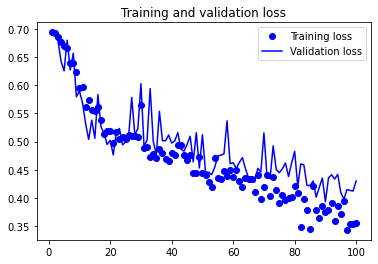

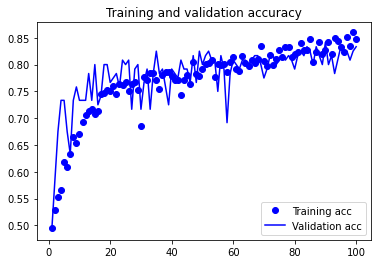

<Figure size 432x288 with 0 Axes>

In [81]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [70]:
test_labels = test_gen.classes
test_labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [71]:
test_gen.class_indices

{'Normal': 0, 'Thoracic': 1}

In [72]:
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
12/12 [==============================] - 1s 61ms/step


In [73]:
predictions.shape

(120, 2)

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [75]:
test_labels.shape

(120,)

In [76]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [77]:
test_gen.class_indices

{'Normal': 0, 'Thoracic': 1}

Confusion matrix, without normalization
[[51 10]
 [13 46]]


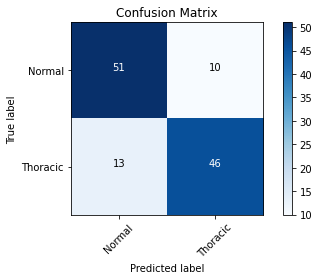

In [78]:
cm_plot_labels = ['Normal', 'Thoracic']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [79]:
test_filenames = test_gen.filenames
y_true = test_gen.classes
y_pred = predictions.argmax(axis=1)

In [80]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)
print(report)


              precision    recall  f1-score   support

      Normal       0.80      0.84      0.82        61
    Thoracic       0.82      0.78      0.80        59

    accuracy                           0.81       120
   macro avg       0.81      0.81      0.81       120
weighted avg       0.81      0.81      0.81       120

